# Dating of Medieval Manuscript Images with Artificial Neural Networks

This notebook contains a basic python implementation of a neural classifier that performs dating on images of Medieval handwritten documents. While the source code is compact it isn't terribly abstracted and is intended to be tinkered with.

It is trained, or rather fine-tuned, on a dataset called [CLAMM](https://clamm.irht.cnrs.fr/icdar-2017/icdar2017-clamm/) (Classification of Medieval Handwritings in Latin Script) prepared by the [IRHT](https://www.irht.cnrs.fr) (Institut de recherche et d'histoire des textes). The dataset was prepared for a competition on document classification at ICDAR 2017. The prevailing method at the time achieved an accuracy of ~80%.



## Housekeeping

The first part of our code mounts the datasets from my google drive:

In [1]:
!gdown -c 12-E7jW4IDLxkJi-aO6e6ZsyRgSZ4JcSw
!unzip /content/clamm.zip

Downloading...
From: https://drive.google.com/uc?id=12-E7jW4IDLxkJi-aO6e6ZsyRgSZ4JcSw
To: /content/clamm.zip
100% 2.73G/2.73G [00:31<00:00, 85.5MB/s]
Archive:  /content/clamm.zip
   creating: ICDAR2017_CLaMM_task1_task3/
  inflating: ICDAR2017_CLaMM_task1_task3/@ICDAR2017_CLaMM_task1_task3.csv  
  inflating: ICDAR2017_CLaMM_task1_task3/train_clamm.py  
   creating: ICDAR2017_CLaMM_task1_task3/imgs/
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/IRHT_P_006544.jpg  
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/IRHT_P_007826.jpg  
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/IRHT_P_004753.jpg  
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/IRHT_P_003793.jpg  
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/btv1b90767290_f40_2.jpg  
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/IRHT_P_008606.jpg  
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/IRHT_P_008515.jpg  
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/IRHT_P_006407.jpg  
  inflating: ICDAR2017_CLaMM_task1_task3/imgs/IRHT_P_008238.jpg 

In [2]:
%cd ICDAR2017_CLaMM_task1_task3

/content/ICDAR2017_CLaMM_task1_task3


installs all the requirements, principally the timm package predefining image classification models, the pytorch-lightning abstraction layer, and the pytorch machine learning library:

In [3]:
!pip install -q timm torch pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 25.2 MB/s eta 0:00:00


Next we import the parts of the installed library necessary for our training:

In [4]:
import pytorch_lightning as pl
import timm.optim
import timm.scheduler
import torch.nn.functional as F

from timm import utils
from timm.data import create_dataset, create_loader
from timm.data.transforms_factory import create_transform
from pytorch_lightning.callbacks import RichProgressBar

from torchvision.transforms import ToPILImage
to_img = ToPILImage()

and we define a very simple mapping between our periods and classification indices. Our trained neural network will output a `1` when it believes a document to be written between 1001 and 1100 CE, a `2` for 1101 and 1200 CE, and so on:

In [5]:
class_to_idx = {'-1000': 0,
                '1001-1100': 1,
                '1101-1200': 2,
                '1201-1250': 3,
                '1251-1300': 4,
                '1301-1350': 5,
                '1351-1400': 6,
                '1401-1425': 7,
                '1426-1450': 8,
                '1451-1475': 9,
                '1476-1500': 10,
                '1501-1525': 11,
                '1526-1550': 12,
                '1551-1575': 13,
                '1576-1600': 14}

idx_to_class = {0: '-1000',
                1: '1001-1100',
                2: '1101-1200',
                3: '1201-1250',
               Housekeeping 4: '1251-1300',
                5: '1301-1350',
                6: '1351-1400',
                7: '1401-1425',
                8: '1426-1450',
                9: '1451-1475',
                10: '1476-1500',
                11: '1501-1525',
                12: '1526-1550',
                13: '1551-1575',
                14: '1576-1600'}

## Interlude: Pytorch/Training Crash Course

Neural networks (NNs) are a collection of nested functions that are executed on some input data. These functions are defined by parameters, weights and biases.

Training a NN happens in two steps:

**Forward Propagation**: In forward prop, the NN makes its best guess about the correct output. It runs the input data through each of its functions to make this guess.

**Backward Propagation**: In backprop, the NN adjusts its parameters proportionate to the error in its guess. It does this by traversing backwards from the output, collecting the derivatives of the error with respect to the parameters of the functions (gradients), and optimizing the parameters using gradient descent. In simpler terms it determines the impact of each parameter on the final error and adjusts them to reduce this error.

We will first look at an artificial example of a training step to see what is going on when we train a NN. For this we create a type of convolutional neural network (CNN) called a ResNet18, input data as a random tensor (torch's equivalent of numpy arrays) with size `(1, 3, 64, 64)`, and target labels as a random tensor of size `(1, 1000)`. The `data` tensor corresponds to a single (`1`), RGB (`3`) image with a height of 64 pixels and a width of 64 pixels.The `labels` tensor corresponds to `1000` different classes:

In [2]:
import torch
from torchvision.models import resnet18
model = resnet18()
data = torch.rand(1, 3, 64, 64)
labels = torch.rand(1, 1000)

Next, we run the input data through the model through each of its layers to make a prediction. This is the forward pass.

In [8]:
prediction = model(data)

We use the model’s prediction and the corresponding label to calculate the error (loss). The next step is to backpropagate this error through the network. In this example we're using the absolute difference as a loss, but pytorch implements other [loss](https://pytorch.org/docs/stable/nn.html#loss-functions) functions as well. Backward propagation is kicked off when we call .backward() on the error tensor:

In [9]:
loss = (prediction - labels).sum()
print(loss)
loss.backward() # backward pass

tensor(-4537.2427, grad_fn=<SumBackward0>)


We could use the backpropagated loss directly to adjust the parameters of the network. This isn't done in practice because using the whole error signal would push the parameter values around too much for the network to learn anything. Therefore the signal is usually reduced by a factor called the **learning rate**. In addition, there are multiple other techniques that increase the stability of the training process. An algorithm employing a certain ensemble of these techniques is called an **optimizer**. There are [many different optimizers implemented in pytorch](https://pytorch.org/docs/stable/optim.html).

In [10]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

After we've backpropagated the loss through the network we call the optimizer to actually change the parameters of the network:

In [11]:
optim.step()

This process will be completed over and over again with new samples in something called a training loop. Periodically, training will be interrupted to evaluate the training progress against a dataset that isn't used to optimize the network (validation).

## Lightning

While we can train a model with pure pytorch, it is quite tedious and requires a lot of repetitive (boilerplate) source code. Quite often people rely on abstraction libraries like lightning reduce the amount of code required substantially.

Continuing where we left off with our manuscript dating data, we can now define a neural network and dataset. Lightning encapsulates most specific configuration of your neural model inside a single class called a [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html). A LightningModule contains a initialization section, a training loop, a validation loop, optimizers, and optionally dataset/dataloader (pytorch's helper classes to access training data during training) methods.

The top part uses a particular neural network architecture called an `EfficientNetV2`, that has already been pretrained on another dataset (ImageNet). Through a process called fine-tuning we can 'recycle' a lot of the general knowledge about the structure of objects in images that network has to be able to train our model with less training data and to a higher accuracy.

This is followed by the actual training step. As explained neural networks train by comparing the actual output (`outputs`) of the neural network for an input (`inputs`) to the desired one (`targets`) with a loss function (in this case `cross_entropy`). The optimizer is responsible for determining how each part of the neural network should be changed according to the error signal from the loss function.

The bottom part simply loads our training and validation data. We use helper classes from the timm library as our dataset corresponds to a simple classification task with the CLAMM dataset being in a standardized format (ImageNet) already. For other tasks one usually has to write custom dataset classes.

In [6]:
class ClammClassifier(pl.LightningModule):
    def __init__(self,
                 lr=0.0004,
                 batch_size=48):
        super().__init__()
        self.lr = lr
        self.batch_size = batch_size
        self.save_hyperparameters()
        self.model = timm.create_model('tf_efficientnetv2_s_in21ft1k', pretrained=True, num_classes=len(class_to_idx))

    def configure_optimizers(self):
        optimizer = timm.optim.AdamP(self.model.parameters(), self.lr)
        return optimizer

    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, idx):
        inputs, targets = batch
        outputs = self.model(inputs)
        loss = F.cross_entropy(outputs, targets)
        self.log('train_loss',loss)
        return loss

    def validation_step(self, batch, idx):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, targets)
        acc1, acc5 = utils.accuracy(outputs, targets, topk=(1, 5))
        self.log_dict({'val_loss': loss,
                       'acc1': acc1,
                       'acc5': acc5},
                       on_step=False,
                       on_epoch=True,
                       prog_bar=True)

    def train_dataloader(self):
        dataset_train = create_dataset(name='',
                                       root='training',
                                       is_training=True,
                                       class_map=class_to_idx,
                                       batch_size=self.batch_size)

        return create_loader(dataset_train,
                             is_training=True,
                             input_size=self.model.default_cfg['input_size'],
                             batch_size=self.batch_size,
                             interpolation=self.model.default_cfg['interpolation'],
                             mean=self.model.default_cfg['mean'],
                             std=self.model.default_cfg['std'],
                             num_workers=2)

    def val_dataloader(self):
        dataset_val = create_dataset(name='',
                                     root='validation',
                                     is_training=False,
                                     class_map=class_to_idx,
                                     batch_size=self.batch_size)

        return create_loader(dataset_val,
                             is_training=False,
                             input_size=self.model.default_cfg['input_size'],
                             batch_size=self.batch_size,
                             interpolation=self.model.default_cfg['interpolation'],
                             mean=self.model.default_cfg['mean'],
                             std=self.model.default_cfg['std'],
                             num_workers=2)

model = ClammClassifier()

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnetv2_s_in21ft1k to current tf_efficientnetv2_s.in21k_ft_in1k.
  model = create_fn(


When fine-tuning a model for a new task the final classification layer is reinitialized to correspond to the dimensionality, i.e. number of classes, of our classification problem. The `timm.create_model()` function in the LightningModule performs this task automatically for us:

In [7]:
print(model.model)
print(len(idx_to_class))

EfficientNet(
  (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
   

Here we instantiate what is called a trainer. The trainer encapsulates our training process and determines where and how it is run (CPU, GPU, ...):

In [8]:
num_epochs = 20
trainer = pl.Trainer(max_epochs=num_epochs, accelerator="gpu", devices=1, callbacks=RichProgressBar(leave=True), precision=16)

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


During training the dataset will be shown to the network one complete time (`epoch`). Afterwards it is run on the validation set to determine how well it has adapted to the particular task. In our case we train for a fixed number of epochs.

In [ ]:
trainer.fit(model)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name  ┃ Type         ┃ Params ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ model │ EfficientNet │ 20.2 M │
└───┴───────┴──────────────┴────────┘

Trainable params: 20.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 20.2 M                                                                                               
Total estimated model params size (MB): 40

Output()

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number 
of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for 
log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(

The arguments to the model like learning rate, batch size, number of epochs, and neural network architecture are called hyperparameters. Hyperparameter selection is an extremely important part of designing a machine learning system as the accuracy, resource consumption, and training effort required can vary substantially. Bad hyperparameters can even keep your model from converging (learning) at all.

Our example is somewhat simplistic. The NN we use is fixed and only the learning rate, batch size, and epochs are exposed. Most practical NN will have many more hyperparameters that can be tweaked. Nevertheless, try fiddling around with the hyperparameters available. **What happens if we increase the batch size? Which impact have changes of the learning rate?**

## Inference

Once trained, we can use our trained model to perform inference and run it on unknown images:

In [9]:
model.eval()
val_loader = model.val_dataloader()

imgs, labels = next(iter(val_loader))

In [10]:
print(imgs.shape)
print(labels)

torch.Size([48, 3, 300, 300])
tensor([1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8],
       device='cuda:0')


Taking an arbitrary image from our batch of validation data and running it through the model:

In [22]:
o = model(imgs[10].unsqueeze(0).cpu())
print(f'output: {o} \nshape: {o.shape}')

output: tensor([[-1.2438,  2.2218,  5.8615,  3.6191, -4.5927, -5.5598, -5.7692,  1.1194,
          2.4379,  6.8544, -1.5712, -0.5240, -0.2296,  2.7544,  4.7969]],
       grad_fn=<AddmmBackward0>) 
shape: torch.Size([1, 15])


What do these numbers mean? They are obviously not probabilities. From the shape of the output we can deduce that each entry in the tensor corresponds to a individual class.

These raw outputs from a machine learning model are called **logits**. Depending on the type of model these logits need to be fed through an **activation function** to be interpretable by a human. One of the most common activation function is the softmax function which produces a probability distribution over one dimension of the output tensor:

In [20]:
pdf = F.softmax(o, dim=-1)
print(f'{pdf}')
print(f'cls: {pdf.argmax()}')

tensor([[1.9232e-04, 6.1530e-03, 2.3430e-01, 2.4884e-02, 6.7548e-06, 2.5679e-06,
         2.0827e-06, 2.0433e-03, 7.6378e-03, 6.3242e-01, 1.3861e-04, 3.9501e-04,
         5.3024e-04, 1.0481e-02, 8.0806e-02]], grad_fn=<SoftmaxBackward0>)
cls: 9


In our case, a simple classification, there is no need for this transformation as the highest-valued logit will also be the highest-valued entry after normalization with the softmax function:

In [23]:
print(f'softmax_cls: {pdf.argmax()} o_cls: {o.argmax()}')

softmax_cls: 9 o_cls: 9


Therefore for arbitrary images:

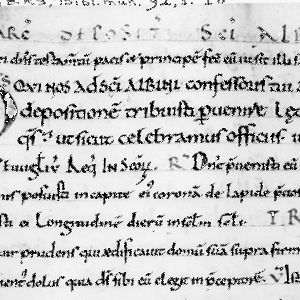

1001-1100 1001-1100


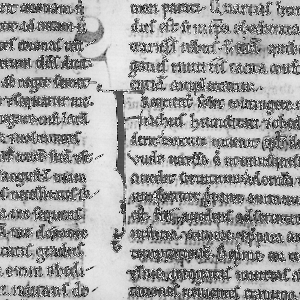

1201-1250 1201-1250


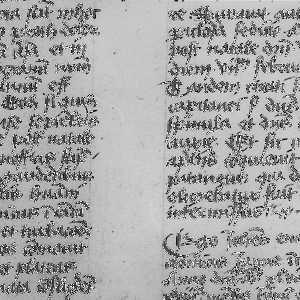

1426-1450 1426-1450


In [ ]:
display(to_img(imgs[0]))
prediction = model(imgs[0].unsqueeze(0).cpu()).argmax()
print(f'{idx_to_class[int(prediction)]} {idx_to_class[int(labels[0])]}')

display(to_img(imgs[22]))
prediction = model(imgs[22].unsqueeze(0).cpu()).argmax()
print(f'{idx_to_class[int(prediction)]} {idx_to_class[int(labels[22])]}')

display(to_img(imgs[45]))
prediction = model(imgs[45].unsqueeze(0).cpu()).argmax()
print(f'{idx_to_class[int(prediction)]} {idx_to_class[int(labels[45])]}')